In [11]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math, decimal
import requests
dec = decimal.Decimal
import krakenex
from pykrakenapi import KrakenAPI
api = krakenex.API()
k = KrakenAPI(api)
FearGreedUrl = requests.get('https://api.alternative.me/fng/?limit=2').json()

In [12]:
from pathlib import Path
csvpath1 = Path("./full_moon.csv")

In [13]:
full_moon = pd.read_csv(csvpath1, parse_dates=True, index_col=' Date', infer_datetime_format=True)
full_moon.reset_index(inplace=True)
full_moon = full_moon.rename(columns = {' Date':'Full Moon'})
full_moon.drop(['Day',' Time'], axis=1, inplace=True)

In [14]:
full_moon['New Moon'] = full_moon['Full Moon'] + timedelta(days=14)
full_moon

,Full Moon,New Moon
0,1900-01-15,1900-01-29
1,1900-02-14,1900-02-28
2,1900-03-16,1900-03-30
3,1900-04-15,1900-04-29
4,1900-05-14,1900-05-28
...,...,...
1863,2050-09-01,2050-09-15
1864,2050-09-30,2050-10-14
1865,2050-10-30,2050-11-13
1866,2050-11-28,2050-12-12


In [15]:
ohlc = k.get_ohlc_data('BTCUSD', interval=1440, ascending = True)
Price = ohlc[0]['Price'] = ohlc[0]['close'].rolling(1).mean()
ohlc[0].drop(['high', 'low', 'time', 'open', 'close', 'vwap', 'count', 'volume'], axis = 1).tail()

,Price
dtime,
2022-04-20,41369.9
2022-04-21,40484.1
2022-04-22,39715.9
2022-04-23,39435.6
2022-04-24,39480.2


In [16]:
# Create a Moon Data table with the BTC Price data for each Full and New Moon date

full_moon = full_moon.join(ohlc[0]['Price'], on = 'Full Moon', how = 'inner')
full_moon['Full Moon Price'] = full_moon['Price']
full_moon = full_moon.drop(columns=['Price'])

full_moon = full_moon.join(ohlc[0]['Price'], on = 'New Moon', how = 'inner')
full_moon['New Moon Price'] = full_moon['Price']
full_moon = full_moon.drop(columns=['Price'])
moon_data = full_moon
moon_data

,Full Moon,New Moon,Full Moon Price,New Moon Price
1488,2020-05-07,2020-05-21,10001.0,9057.3
1489,2020-06-05,2020-06-19,9617.7,9302.1
1490,2020-07-05,2020-07-19,9083.8,9213.7
1491,2020-08-03,2020-08-17,11237.3,12301.7
1492,2020-09-02,2020-09-16,11396.9,10951.1
1493,2020-10-01,2020-10-15,10616.1,11501.0
1494,2020-10-31,2020-11-14,13809.1,16080.1
1495,2020-11-30,2020-12-14,19708.1,19281.1
1496,2020-12-30,2021-01-13,28879.9,37390.1
1497,2021-01-28,2021-02-11,33430.4,47962.8


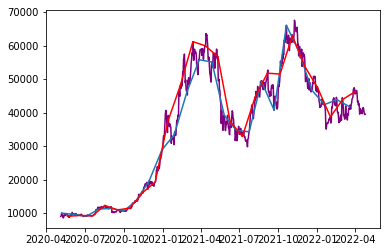

In [24]:
# Show the BTC Price over time

x = pd.DataFrame(ohlc[0]['Price']).index.to_numpy()
y = pd.DataFrame(ohlc[0]['Price']).to_numpy()
plt.plot(x,y, color='purple')

x = pd.DataFrame(moon_data['Full Moon']).to_numpy()
y = pd.DataFrame(moon_data['Full Moon Price']).to_numpy()
plt.plot(x,y)

x = pd.DataFrame(moon_data['New Moon']).to_numpy()
y = pd.DataFrame(moon_data['New Moon Price']).to_numpy()
plt.plot(x,y, color='red')

plt.show()
